# Ensemble NMS - Detectron2 [Inference]

### Hi kagglers, This is `Ensemble NMS - Detectron2 [Inference]` notebook.
* [Sartorius Segmentation - Detectron2 [training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-training) 
* [Sartorius Segmentation - Detectron2 [Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-inference) 
* [K-fold CrossValidation COCO Dataset Generator](https://www.kaggle.com/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator) 


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

## Other notebooks in this competition 
- [Sartorius Segmentation - Keras U-Net[Training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-training)
- [Sartorius Segmentation - Keras U-Net[Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-inference/edit)

# Intro
Ensembling multiple weaker performing models can help to get the results that you want.

## Install and import libraries

In [1]:
# !pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls &>/dev/null
# !pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/ensemble-boxes-104/ensemble_boxes-1.0.4/ -f ./ --no-index  &>/dev/null

In [1]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import *
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

GPU is available
detectron ver: 0.6


## My Models

In [2]:
best_model=( {'file': 'model_best_fold_1.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.307, 'ths':[0.5, 0.65, 0.5], 'pxls': [70, 75, 70]},
             {'file': 'model_best_fold_2.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.315, 'ths':[0.5, 0.575, 0.5], 'pxls': [60, 60, 130]},
             {'file': 'model_best_fold_3.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.297, 'ths':[0.5, 0.6, 0.5], 'pxls': [70, 75, 70]},
             {'file': 'model_best_fold_4.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.295, 'ths':[0.5, 0.6, 0.5], 'pxls': [70, 75, 70]})

In [3]:
#config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mdl_path = "output"
DATA_PATH = "sartorius-cell-instance-segmentation"
MODELS = []
BEST_MODELS =[]
THSS = []
PXLS = []
ID_TEST = 0
SUBM_PATH = f'{DATA_PATH}/test'
SINGLE_MODE = False
NMS = True
MIN_PIXELS = [60, 60, 60]
IOU_TH = .4
for b_m in best_model:
    model_name=b_m["file"]
    model_ths=b_m["ths"]
    model_pxls=b_m["pxls"]
    config_name=b_m["config_name"]
    BEST_MODELS.append(model_name)
    THSS.append(model_ths)
    PXLS.append(model_pxls)
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    cfg.MODEL.WEIGHTS = f'{mdl_path}/{model_name}'  
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    MODELS.append(DefaultPredictor(cfg))
print(f'all loaded:\nthresholds: {THSS}\nmodels: {BEST_MODELS}')

all loaded:
thresholds: [[0.5, 0.65, 0.5], [0.5, 0.575, 0.5], [0.5, 0.65, 0.5], [0.5, 0.65, 0.5]]
models: ['model_best_fold_1.pth', 'model_best_fold_2.pth', 'model_best_fold_3.pth', 'model_best_fold_4.pth']


In [4]:
MODELS

## Utils

In [14]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_preds(file_name, path, models, ths):
    img = cv2.imread(f'{path}/{file_name}')
    classes = []
    scores = []
    bboxes = []
    masks = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= ths[i][pred_class]
        classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
#     scores, classes, bboxes, masks = zip(*sorted(zip(scores, classes, bboxes, masks), reverse=True))
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def ensemble_get_masks(masks, classes, pxls, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= pxls[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

## Demo inference

In [6]:
test_names = os.listdir(SUBM_PATH)
print('test images:', len(test_names))

test images: 3


In [31]:
encoded_masks_single = get_masks(
    test_names[ID_TEST], 
    path=SUBM_PATH, 
    model=MODELS[0],
    ths=THSS[0],
    min_pixels=MIN_PIXELS
)

classes, scores, bboxes, masks = ensemble_preds(
    file_name=test_names[ID_TEST] , 
    path=SUBM_PATH, 
    models=MODELS, 
    ths=THSS
)

if NMS:
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes,
        masks, iou_th=IOU_TH
    )
    
encoded_masks = ensemble_get_masks(masks, classes, pxls=MIN_PIXELS)

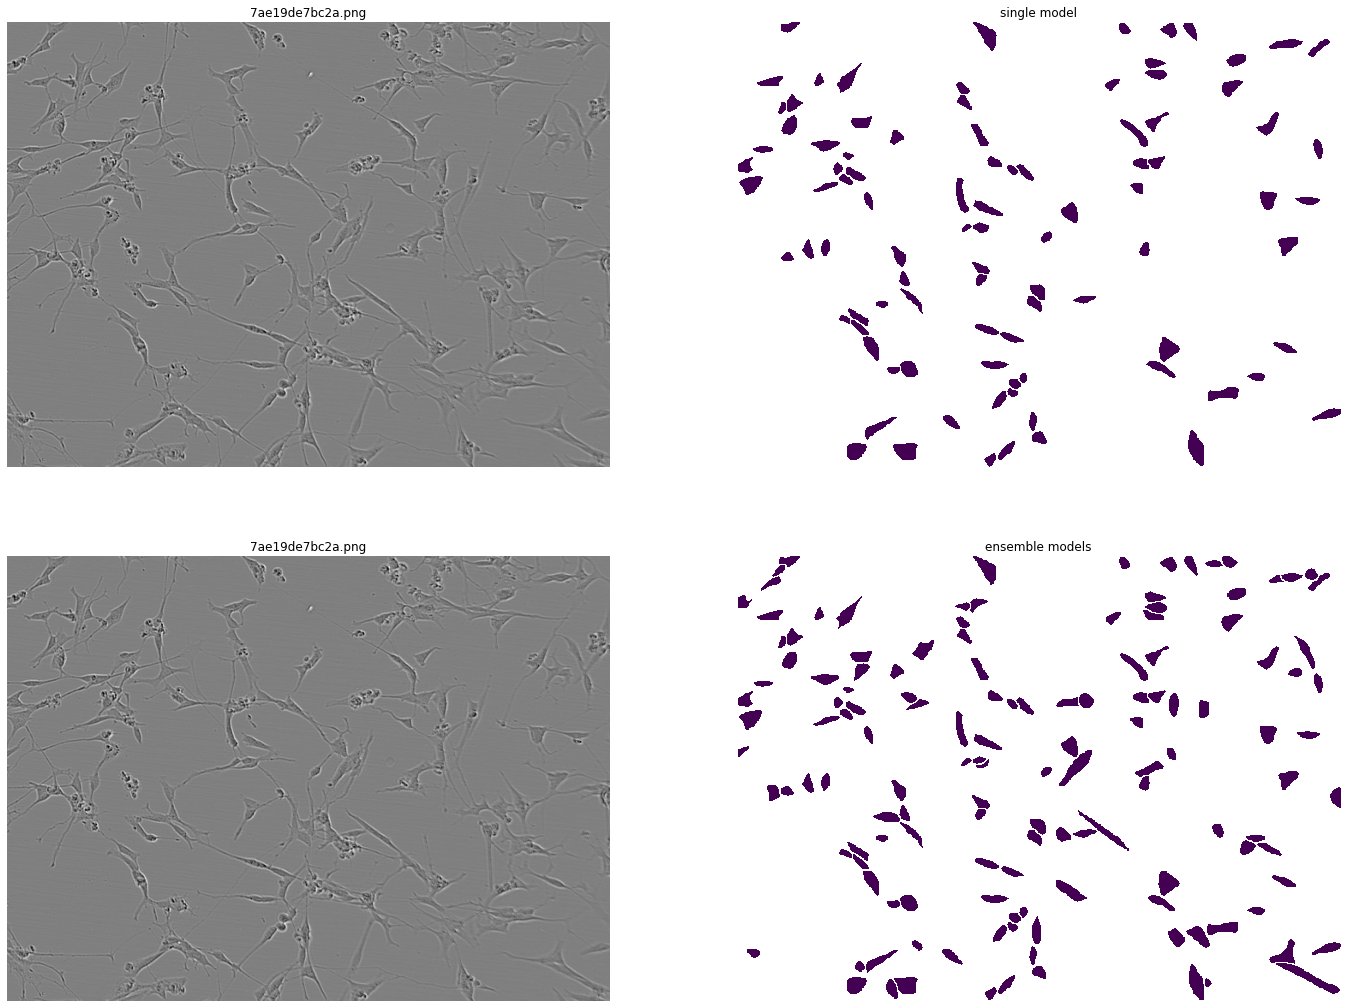

In [32]:
_, axs = plt.subplots(2, 2, figsize=(24, 18))
axs[0][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[0][0].axis('off')
axs[0][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_single:
    dec_mask = rle_decode(en_mask)
    axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[0][1].axis('off')
    axs[0][1].set_title('single model')
axs[1][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[1][0].axis('off')
axs[1][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks:
    dec_mask = rle_decode(en_mask)
    axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[1][1].axis('off')
    axs[1][1].set_title('ensemble models')
plt.show()

## Inference

In [ ]:
subm_ids, subm_masks = [], []
for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = get_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS[0],
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_get_masks(
            masks, 
            classes, 
            pxls=MIN_PIXELS
        )
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        subm_masks.append(enc_mask)

In [ ]:
pd.DataFrame({
    'id': subm_ids, 
    'predicted': subm_masks
}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

# References
1. https://www.kaggle.com/vgarshin/detectron2-inference-with-ensemble-and-nms